# Model Building & Evaluation
## Building and Comparing Multiple Models for Market Prediction

This notebook covers:
1. Data preparation for modeling
2. Train-test split
3. Model training (Multiple algorithms)
4. Model evaluation and comparison
5. Hyperparameter tuning
6. Saving the best model

In [1]:
# Install additional packages if needed
!pip install xgboost lightgbm scikit-learn joblib

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

print('Libraries imported successfully!')

Libraries imported successfully!


## Step 1: Load Processed Data

In [7]:
# Load the processed data
df = pd.read_csv('../data/processed_market_data.csv', index_col=0, parse_dates=True)

print(f'Data loaded successfully!')
print(f'Shape: {df.shape}')
print(f'\nColumns: {list(df.columns)}')
df.head()

Data loaded successfully!
Shape: (1481, 34)

Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Daily_Return', 'Price_Range', 'Price_Change', 'Volume_MA_5', 'Volume_Ratio', 'Volatility', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5', 'Close_Lag_7', 'Volume_Lag_7', 'Target']


,Close,High,Low,Open,Volume,MA_5,MA_10,MA_20,MA_50,EMA_12,...,Volume_Lag_1,Close_Lag_2,Volume_Lag_2,Close_Lag_3,Volume_Lag_3,Close_Lag_5,Volume_Lag_5,Close_Lag_7,Volume_Lag_7,Target
Price,,,,,,,,,,,,,,,,,,,,,
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-13,67.22760009765625,67.69921444547847,61.17646208174082,64.06417921518192,370732000,65.451923,68.346413,70.773999,73.870379,68.073781,...,418474000.0,66.613297,255598800.0,69.010048,285290000.0,69.902496,226176800.0,73.218292,219178400.0,58.578976
2020-03-16,58.578975677490234,62.65901412516802,58.044481123383505,58.51609179443726,322423600,64.292970,66.977530,69.773457,73.592594,66.613041,...,370732000.0,60.034927,418474000.0,66.613297,255598800.0,64.373741,286744800.0,70.843292,187572800.0,61.154694
2020-03-17,61.154693603515625,62.30348685183075,57.6575122464136,59.860783996429895,324056000,62.721899,66.095736,68.973653,73.380413,65.773296,...,322423600.0,67.227600,370732000.0,60.034927,418474000.0,69.010048,285290000.0,69.902496,226176800.0,59.657635


## Step 2: Feature Selection and Preparation

In [8]:
# Define features to use (exclude OHLCV and target)
exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Target']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f'Number of features: {len(feature_cols)}')
print(f'\nFeatures to be used:')
for i, col in enumerate(feature_cols, 1):
    print(f'{i}. {col}')

Number of features: 28

Features to be used:
1. MA_5
2. MA_10
3. MA_20
4. MA_50
5. EMA_12
6. EMA_26
7. MACD
8. MACD_Signal
9. RSI
10. BB_Middle
11. BB_Upper
12. BB_Lower
13. Daily_Return
14. Price_Range
15. Price_Change
16. Volume_MA_5
17. Volume_Ratio
18. Volatility
19. Close_Lag_1
20. Volume_Lag_1
21. Close_Lag_2
22. Volume_Lag_2
23. Close_Lag_3
24. Volume_Lag_3
25. Close_Lag_5
26. Volume_Lag_5
27. Close_Lag_7
28. Volume_Lag_7


In [9]:
# Prepare X and y
X = df[feature_cols]
y = df['Target']

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Check for any infinite values
print(f'\nInfinite values in X: {np.isinf(X).sum().sum()}')
print(f'Infinite values in y: {np.isinf(y).sum()}')

# Replace infinite values with NaN and drop
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]  # Align y with cleaned X

print(f'\nAfter cleaning:')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (1481, 28)
y shape: (1481,)

Infinite values in X: 0
Infinite values in y: 0

After cleaning:
X shape: (1479, 28)
y shape: (1479,)


## Step 3: Train-Test Split

In [10]:
# Time-series split (important for temporal data)
train_size = int(len(X) * 0.8)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print('Train-Test Split:')
print('='*50)
print(f'Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)')
print(f'Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)')
print(f'\nTrain date range: {X_train.index.min()} to {X_train.index.max()}')
print(f'Test date range: {X_test.index.min()} to {X_test.index.max()}')

Train-Test Split:
Training set: 1183 samples (80.0%)
Test set: 296 samples (20.0%)

Train date range: 2020-03-13 to 2024-11-21
Test date range: 2024-11-22 to 2026-01-30


## Step 4: Feature Scaling

In [12]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for later use
joblib.dump(scaler, '../models/scaler.pkl')
print('Scaler saved to ../models/scaler.pkl')

# Convert back to DataFrame for better visualization
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('\nFeatures scaled successfully!')

Scaler saved to ../models/scaler.pkl

Features scaled successfully!


## Step 5: Model Training and Evaluation

We'll train multiple models and compare their performance

In [13]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1, verbose=-1)
}

print(f'Total models to train: {len(models)}')
print('Models:', list(models.keys()))

Total models to train: 8
Models: ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']


In [14]:
# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return {
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Predictions': y_test_pred
    }

In [15]:
# Train and evaluate all models
results = []
trained_models = {}

print('Training models...')
print('='*70)

for name, model in models.items():
    print(f'\nTraining {name}...')
    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results.append(result)
    trained_models[name] = model

    print(f'  Train RMSE: {result["Train RMSE"]:.4f} | Test RMSE: {result["Test RMSE"]:.4f}')
    print(f'  Train R²: {result["Train R²"]:.4f} | Test R²: {result["Test R²"]:.4f}')

print('\n' + '='*70)
print('All models trained successfully! ✓')

Training models...

Training Linear Regression...
  Train RMSE: 2.6572 | Test RMSE: 4.3038
  Train R²: 0.9950 | Test R²: 0.9720

Training Ridge Regression...
  Train RMSE: 2.7236 | Test RMSE: 4.5971
  Train R²: 0.9948 | Test R²: 0.9680

Training Lasso Regression...
  Train RMSE: 3.2137 | Test RMSE: 5.8586
  Train R²: 0.9927 | Test R²: 0.9481

Training Decision Tree...
  Train RMSE: 0.8498 | Test RMSE: 24.5238
  Train R²: 0.9995 | Test R²: 0.0898

Training Random Forest...
  Train RMSE: 1.2726 | Test RMSE: 23.7532
  Train R²: 0.9989 | Test R²: 0.1461

Training Gradient Boosting...
  Train RMSE: 1.0277 | Test RMSE: 24.6940
  Train R²: 0.9993 | Test R²: 0.0771

Training XGBoost...
  Train RMSE: 1.1386 | Test RMSE: 25.4944
  Train R²: 0.9991 | Test R²: 0.0163

Training LightGBM...
  Train RMSE: 1.5770 | Test RMSE: 24.2209
  Train R²: 0.9982 | Test R²: 0.1121

All models trained successfully! ✓


## Step 6: Model Comparison

In [16]:
# Create results DataFrame (exclude predictions column for display)
results_df = pd.DataFrame(results)
results_display = results_df.drop('Predictions', axis=1)
results_display = results_display.sort_values('Test RMSE')

print('Model Performance Comparison:')
print('='*100)
print(results_display.to_string(index=False))

# Identify best model
best_model_name = results_display.iloc[0]['Model']
print('\n' + '='*100)
print(f'BEST MODEL: {best_model_name}')
print('='*100)

Model Performance Comparison:
            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
Linear Regression    2.657217   4.303790   1.991648  2.910769  0.995031 0.971966
 Ridge Regression    2.723587   4.597141   2.053084  3.089969  0.994780 0.968014
 Lasso Regression    3.213698   5.858622   2.471835  4.430791  0.992732 0.948052
    Random Forest    1.272639  23.753151   0.955243 18.497193  0.998860 0.146071
         LightGBM    1.576994  24.220876   1.192986 18.688416  0.998250 0.112110
    Decision Tree    0.849758  24.523826   0.489201 19.312011  0.999492 0.089760
Gradient Boosting    1.027662  24.693955   0.798348 19.139115  0.999257 0.077087
          XGBoost    1.138607  25.494370   0.869821 19.109423  0.999088 0.016288

BEST MODEL: Linear Regression


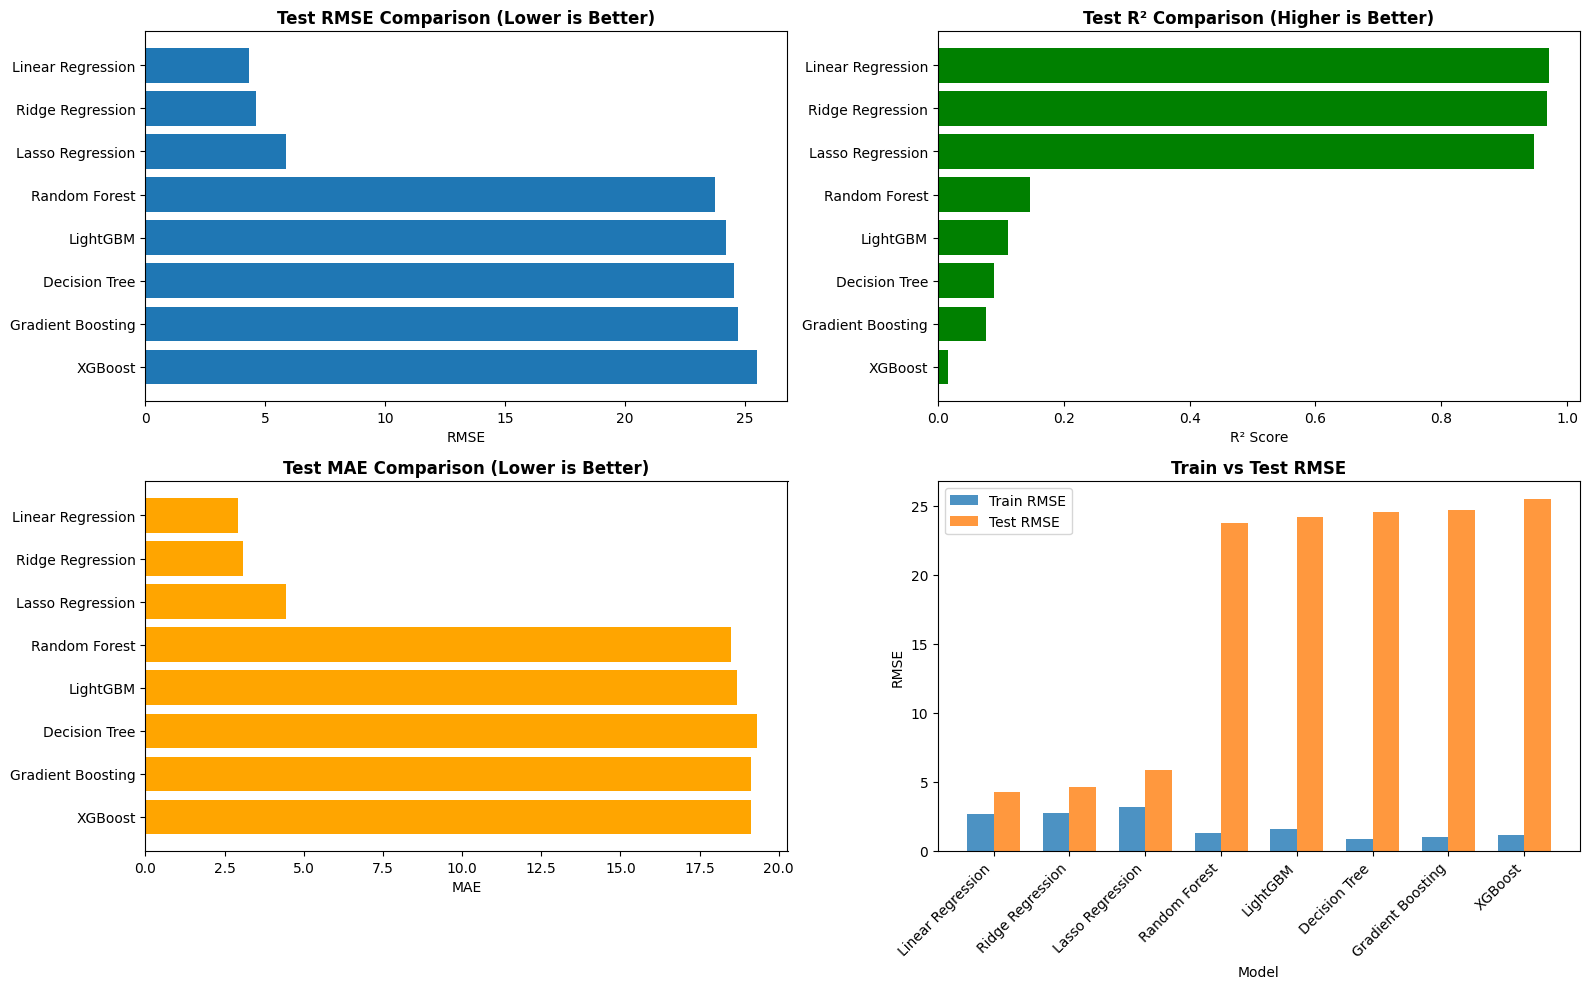

In [17]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Test RMSE Comparison
axes[0, 0].barh(results_display['Model'], results_display['Test RMSE'])
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Test RMSE Comparison (Lower is Better)', fontweight='bold')
axes[0, 0].invert_yaxis()

# 2. Test R² Comparison
axes[0, 1].barh(results_display['Model'], results_display['Test R²'], color='green')
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Test R² Comparison (Higher is Better)', fontweight='bold')
axes[0, 1].invert_yaxis()

# 3. Test MAE Comparison
axes[1, 0].barh(results_display['Model'], results_display['Test MAE'], color='orange')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('Test MAE Comparison (Lower is Better)', fontweight='bold')
axes[1, 0].invert_yaxis()

# 4. Train vs Test RMSE
x = np.arange(len(results_display))
width = 0.35
axes[1, 1].bar(x - width/2, results_display['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1, 1].bar(x + width/2, results_display['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('Train vs Test RMSE', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_display['Model'], rotation=45, ha='right')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Step 7: Detailed Analysis of Best Model

In [18]:
# Get best model
best_model = trained_models[best_model_name]
best_result = results_df[results_df['Model'] == best_model_name].iloc[0]

# Get predictions
y_test_pred = best_result['Predictions']

print(f'Detailed Analysis of {best_model_name}')
print('='*70)
print(f'Test RMSE: ${best_result["Test RMSE"]:.4f}')
print(f'Test MAE: ${best_result["Test MAE"]:.4f}')
print(f'Test R²: {best_result["Test R²"]:.4f}')
print(f'\nInterpretation:')
print(f'- On average, predictions are off by ${best_result["Test MAE"]:.2f}')
print(f'- The model explains {best_result["Test R²"]*100:.2f}% of variance in the target')

Detailed Analysis of Linear Regression
Test RMSE: $4.3038
Test MAE: $2.9108
Test R²: 0.9720

Interpretation:
- On average, predictions are off by $2.91
- The model explains 97.20% of variance in the target


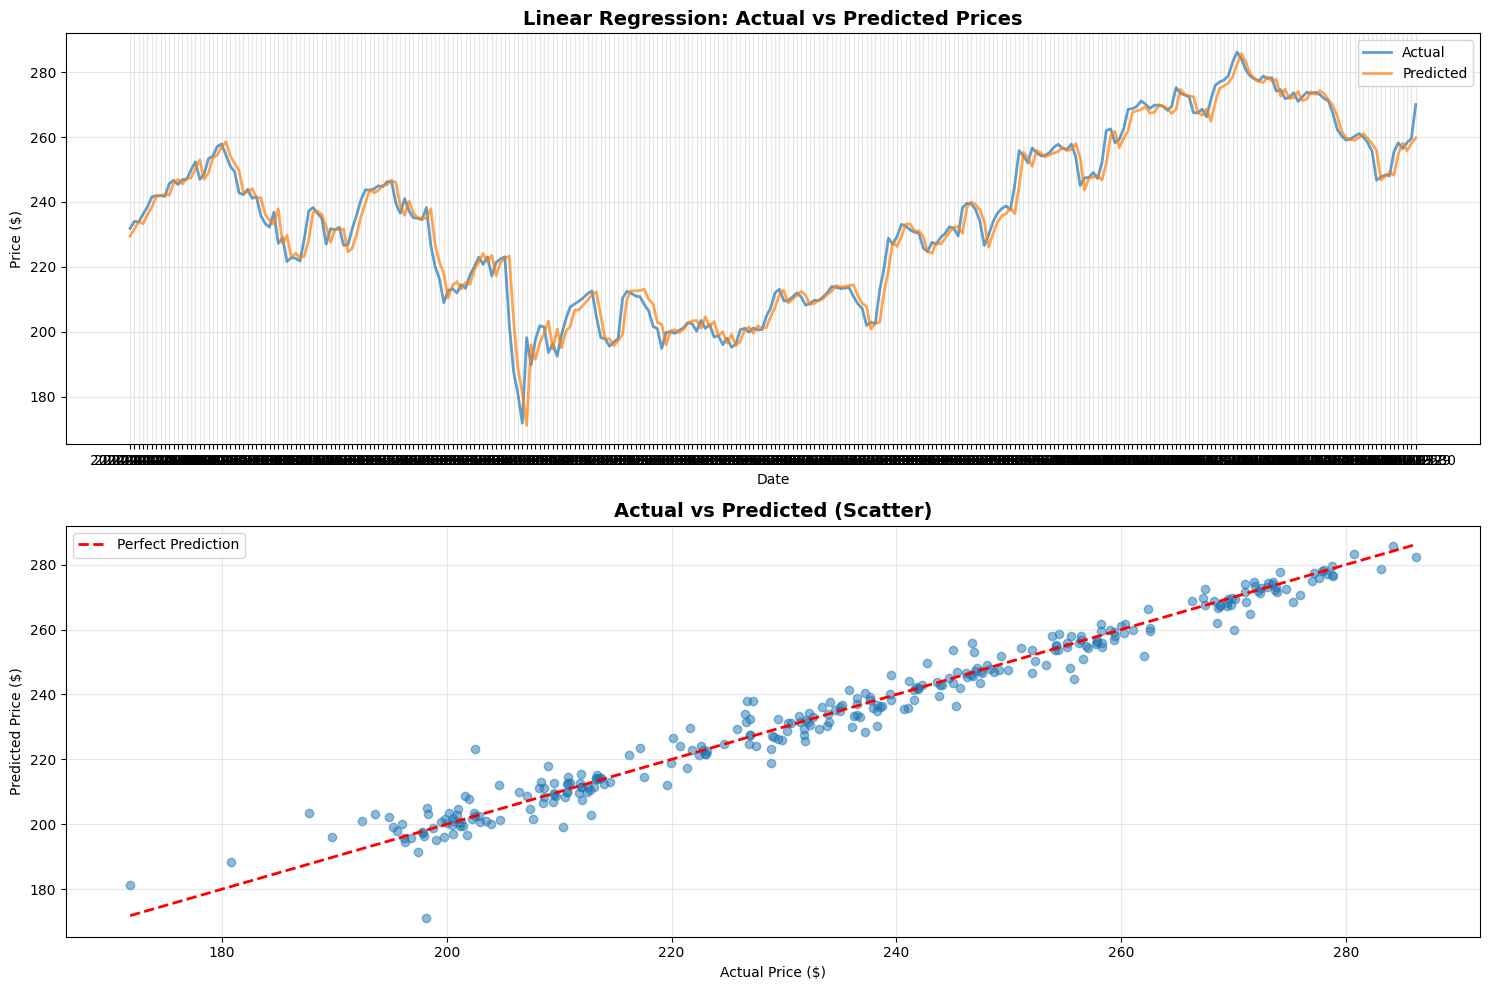

In [19]:
# Visualize predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 1. Time series plot
axes[0].plot(y_test.index, y_test.values, label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(y_test.index, y_test_pred, label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_title(f'{best_model_name}: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Scatter plot
axes[1].scatter(y_test, y_test_pred, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title('Actual vs Predicted (Scatter)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

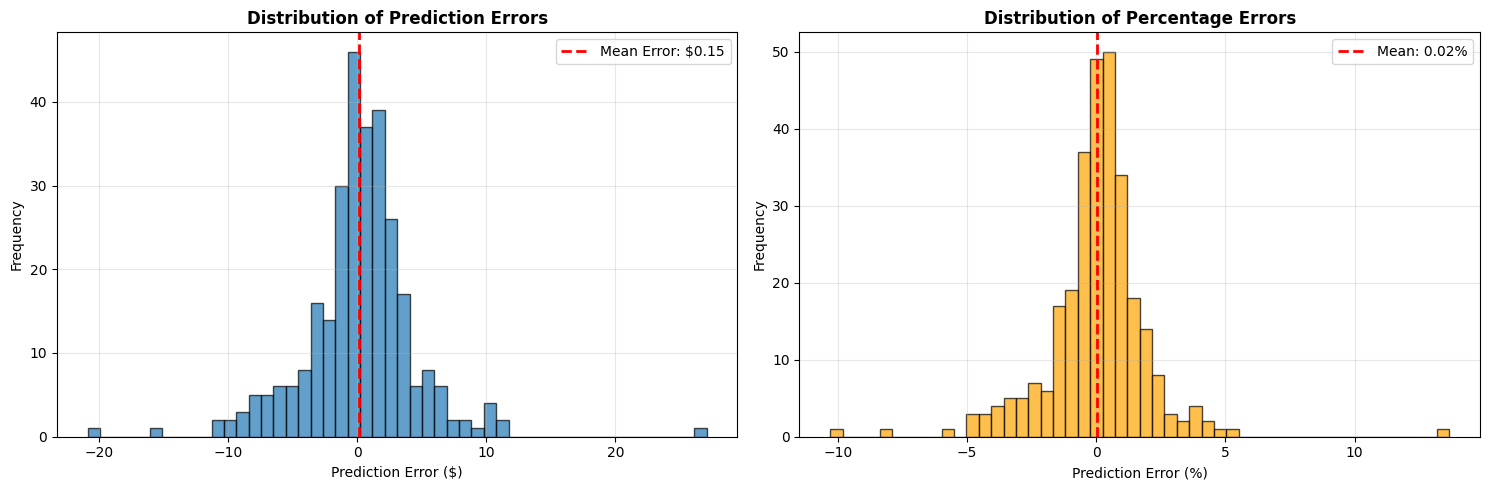

Error Statistics:
Mean Error: $0.1462
Std Dev of Errors: $4.3086
Mean Absolute % Error: 1.29%


In [20]:
# Prediction errors analysis
errors = y_test - y_test_pred
percentage_errors = (errors / y_test) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error distribution
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(errors.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean Error: ${errors.mean():.2f}')
axes[0].set_xlabel('Prediction Error ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Errors', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Percentage error distribution
axes[1].hist(percentage_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(percentage_errors.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {percentage_errors.mean():.2f}%')
axes[1].set_xlabel('Prediction Error (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Percentage Errors', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Error Statistics:')
print('='*50)
print(f'Mean Error: ${errors.mean():.4f}')
print(f'Std Dev of Errors: ${errors.std():.4f}')
print(f'Mean Absolute % Error: {abs(percentage_errors).mean():.2f}%')

## Step 8: Feature Importance (for tree-based models)

In [21]:
# Check if best model has feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print('\nTop 10 Most Important Features:')
    print('='*50)
    print(feature_importance_df.head(10).to_string(index=False))
else:
    print(f'{best_model_name} does not have feature_importances_ attribute.')

Linear Regression does not have feature_importances_ attribute.


## Step 9: Hyperparameter Tuning (Optional but Recommended)

Let's fine-tune the best model

In [22]:
# Define parameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 10],
        'learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 10],
        'learning_rate': [0.01, 0.1]
    }
}

# Check if best model can be tuned
if best_model_name in param_grids:
    print(f'Performing Grid Search for {best_model_name}...')
    print('This may take a few minutes...')

    grid_search = GridSearchCV(
        best_model,
        param_grids[best_model_name],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    print('\nGrid Search Complete!')
    print('='*70)
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Best CV Score (RMSE): {np.sqrt(-grid_search.best_score_):.4f}')

    # Use the best model
    best_model = grid_search.best_estimator_

    # Re-evaluate
    y_test_pred_tuned = best_model.predict(X_test_scaled)
    test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
    test_r2_tuned = r2_score(y_test, y_test_pred_tuned)

    print(f'\nAfter Tuning:')
    print(f'Test RMSE: ${test_rmse_tuned:.4f}')
    print(f'Test R²: {test_r2_tuned:.4f}')

else:
    print(f'No hyperparameter tuning defined for {best_model_name}')
    print('Using the original model...')

No hyperparameter tuning defined for Linear Regression
Using the original model...


## Step 10: Save the Best Model

In [23]:
# Save the best model
model_path = '../models/model.pkl'
joblib.dump(best_model, model_path)
print(f'Best model saved to {model_path}')

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'features': list(X_train.columns),
    'test_rmse': float(best_result['Test RMSE']),
    'test_mae': float(best_result['Test MAE']),
    'test_r2': float(best_result['Test R²']),
    'train_date_range': [str(X_train.index.min()), str(X_train.index.max())],
    'test_date_range': [str(X_test.index.min()), str(X_test.index.max())],
    'training_date': str(pd.Timestamp.now())
}

import json
with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print('Model metadata saved to ../models/model_metadata.json')

print('\n' + '='*70)
print('MODEL BUILDING COMPLETE! ✓')
print('='*70)
print(f'Best Model: {best_model_name}')
print(f'Test RMSE: ${best_result["Test RMSE"]:.4f}')
print(f'Test R²: {best_result["Test R²"]:.4f}')
print('\nNext Steps:')
print('1. Create automation script (monitor.py)')
print('2. Build Streamlit app')
print('3. Set up GitHub Actions for deployment')

Best model saved to ../models/model.pkl
Model metadata saved to ../models/model_metadata.json

MODEL BUILDING COMPLETE! ✓
Best Model: Linear Regression
Test RMSE: $4.3038
Test R²: 0.9720

Next Steps:
1. Create automation script (monitor.py)
2. Build Streamlit app
3. Set up GitHub Actions for deployment
